# Extraindo uma imagem PNG do GEE com o Pillow

Neste notebook, utilizando o exemplo anterior de extração de máscaras, iremos exibir as imagens diretamente no notebook utilizando a biblioteca Pillow e o Request e, posteriormente, savá-la em disco.

Primeiramente, vamos importar as bibliotecas e inicializar o GEE:

In [87]:
# importação da bibliotecas
import ee
import PIL
import requests
from PIL import Image
from io import BytesIO

# inicialização do GEE
ee.Initialize() 

Funções principais utilizadas por esse notebook (comentadas no notebook anterior):

In [88]:
# Função para aplicar à imagem vinda da coleção a máscara de água
def mascara_agua(imagem):
    qa = imagem.select('pixel_qa')
    return qa.bitwiseAnd(1 << 2).eq(0)

# Função para aplicar à imagem vinda da coléção a máscara de nuvem/sombra de nuvem
def mascara_nuvem(imagem):
    qa = imagem.select('pixel_qa')
    return qa.bitwiseAnd(1 << 3).eq(0) and (qa.bitwiseAnd(1 << 5).eq(0)) and (qa.bitwiseAnd(1 << 6).eq(0)) and (qa.bitwiseAnd(1 << 7).eq(0))

# função para aplicar as máscaras
def aplicar_mascaras(imagem):
    
    # criar uma imagem em branco/vazio para evitar problemas no fundo ao gerar um PNG
    # usamos valores dummies (neste caso, branco)
    vazio = ee.Image(99999)
    
    # máscara de água
    agua = vazio.updateMask(mascara_agua(imagem).Not()).rename('agua')
    
    # máscara de nuvem (criará uma imagem com apenas nuvens)
    # caso a imagem não tenha nuvens, ela ficará toda branca
    nuvem = vazio.updateMask(mascara_nuvem(imagem).Not()).rename('nuvem')
    
    # podemos ainda, ao contrário da linha anterior, REMOVER as nuvens
    # notem que retiramos a função .Not (negação)
    sem_nuvem = vazio.updateMask(mascara_nuvem(imagem)).rename('sem_nuvem')
    
    # aplicar o indice NDVI
    ndvi = imagem.expression('(nir - red) / (nir + red)',{'nir':imagem.select('B5'),'red':imagem.select('B4')}).rename('ndvi')
    
    # assim como fizemos para o NDVI, retornamos uma imagem com as novas bandas
    return imagem.addBands([ndvi,agua,nuvem,sem_nuvem])

# função para aplicar uma máscara em uma banda específica
# A mascará a ser aplicada 
def aplicar_mascara_banda(imagem, banda_mascara, banda_origem, band_destino):
    
    # Primeiramente, temos que aplicar a máscara desejada na banda de origem, que será nomeada para a banda de destino
    # Podemos, inclusive, sobscrever a banda de origem, sem problemas
    imagem_mascara = imagem.select(banda_origem).updateMask(imagem.select(banda_mascara)).rename(band_destino)
    
    # Depois, temos que criar uma imagem em branco que receberá a máscara, renomeando também para banda de destino
    imagem_mascara = ee.Image(99999).blend(imagem_mascara).rename(band_destino)
    
    # Retornar a imagem com a nova banda nomeada com a string da banda_destino
    return imagem.addBands([imagem_mascara])

Agora, vamos definir a geometria e as datas (baseada na Latitude e Longitude) da nossa área de estudo e consultá-la no GEE (mesmo do notebook anterior):

In [89]:
# Notem que foi criada uma coordenada (Latitude e Longitude) através de uma string, posteriormente repartida pelas virgulas
# Essa abordagem é importante para quando utilizarmos a linha da comando
coordenadas = "-48.53801472648439,-22.503806214013736,-48.270222978437516,-22.7281869567509"

# Aqui, usamos uma ferramenta do Python chamada de unpacking
x1,y1,x2,y2 = coordenadas.split(",")

# Criamos a geometria com base nas coordenadas 'quebradas' acima
geometria = geometry = ee.Geometry.Polygon(
        [[[float(x1),float(y2)],
          [float(x2),float(y2)],
          [float(x2),float(y1)],
          [float(x1),float(y1)],
          [float(x1),float(y2)]]])

# String de datas
datas = "2014-10-13,2014-10-14"

# Divisão das duas datas pela vírgula, novamente usando a técnica de unpacking
inicio,fim = datas.split(",")

# Consultando a coleção com base na área de estudo e datas selecionadas
colecao = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(geometria).filterDate(inicio,fim).filterMetadata('CLOUD_COVER','less_than', 30)

# aplicar a função 'aplicar_mascaras' em todas as imagens (irá adicionar as bandas 'agua', 'nuvem', 'sem_nuvem' nas imagens):
colecao = colecao.map(aplicar_mascaras)

# extraindo a imagem mediana da coleção
imagem = colecao.median()

Agora, vamos aplicar as máscaras individualmente na banda NDVI:

In [90]:
# Aplicamos as três máscaras individualmente na banda NDVI
# A função irá adicionar as já mencionadas bandas de origem a medida que for sendo executada, linha a linha
imagem = aplicar_mascara_banda(imagem, 'agua', 'ndvi', 'ndvi_agua')
imagem = aplicar_mascara_banda(imagem, 'nuvem', 'ndvi', 'ndvi_nuvem')
imagem = aplicar_mascara_banda(imagem, 'sem_nuvem', 'ndvi', 'ndvi_sem_nuvem')
imagem = aplicar_mascara_banda(imagem, 'agua', 'ndvi_sem_nuvem', 'ndvi_agua_sem_nuvem')

# Depois, cortamos a imagem
# scale = escala do sensor. No caso do Landsat-8/OLI são 30 metros
imagem_corte = imagem.clipToBoundsAndScale(geometry=geometria,scale=30)

Utilizando o Pillow e o Request, iremos exibir extrair uma imagem da banda 'ndvi_agua_sem_nuvem' através da plataforma GEE:

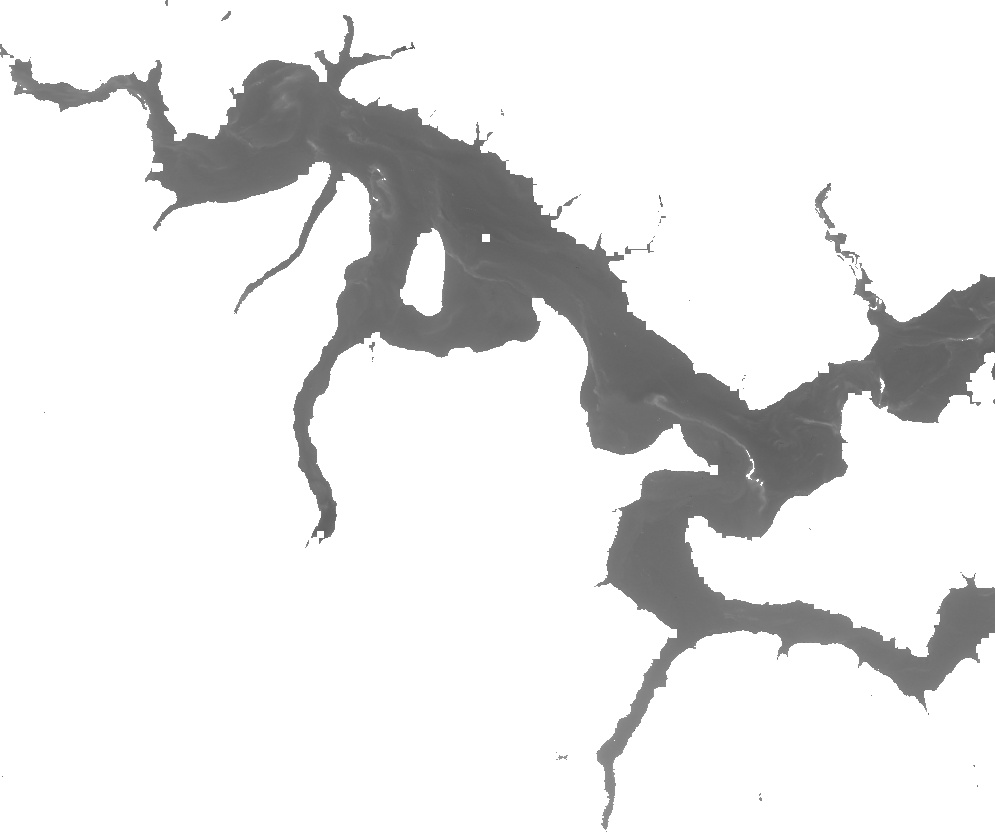

In [91]:
# Exibindo a imagem com o Pillow, Requests e BytesIO diretamente no notebook
PIL.Image.open(BytesIO(requests.get(imagem_corte.select(['ndvi_agua_sem_nuvem']).getThumbUrl({'min':-1, 'max':1})).content))

Essa imagem pode ser, inclusive, salva em um arquivo com o comando:

In [92]:
# Salvar imagem em um arquivo
imagem_pillow = PIL.Image.open(BytesIO(requests.get(imagem_corte.select(['ndvi_agua_sem_nuvem']).getThumbUrl({'min':-1, 'max':1})).content))
imagem_pillow.save('images/7-ndvi_bbhr.png')

### Verifiquem a imagem '7-ndvi_bbhr.png' na pasta 'images'